In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from preprocessing import clean_text

2024-04-01 20:42:16.498899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 20:42:16.531855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 20:42:16.532572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 20:42:17.191536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# BiLSTM

In [3]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.head()

,id,title,text,generated
0,63064638,Sexhow railway station,Sexhow railway station was a railway station b...,0
1,18704707,Sexhow railway station,Sexhow railway station was a railway station l...,1
2,279621,Etiäinen,"In Finnish folklore, all places and things, an...",0
3,58254742,Etiäinen,"In Finnish folklore, all places and things, an...",1
4,287229,Inverse function theorem,"In mathematics, specifically differential calc...",0


In [4]:
preprocessed_texts = []
for text in df['text']:
    preprocessed_texts.append(clean_text(text))

In [5]:
df['preprocessed_text'] = [' '.join(text) for text in preprocessed_texts]
df.head()

,id,title,text,generated,preprocessed_text
0,63064638,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,18704707,Sexhow railway station,Sexhow railway station was a railway station l...,1,sexhow railway station railway station located...
2,279621,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
3,58254742,Etiäinen,"In Finnish folklore, all places and things, an...",1,finnish folklore place thing animate inanimate...
4,287229,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...


# Splitting the Data

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_valid_index in split.split(df, df['generated']):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set['generated']):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [14]:
# v3

train_set = df[:180000]
valid_set = df[180000:240000]
test_set = df[240000:]

In [15]:
x_train = train_set['preprocessed_text']
y_train = np.array(train_set['generated'])

x_test = test_set['preprocessed_text']
y_test = np.array(test_set['generated'])

x_valid = valid_set['preprocessed_text']
y_valid = np.array(valid_set['generated'])

In [16]:
x_train.shape, x_test.shape, x_valid.shape

((180000,), (60000,), (60000,))

# Prepare the Data for Modeling

To feed data to an LSTM, all sequences (all texts) must be of the same length and shaped appropriately.

In [17]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([x_train, x_valid], axis=0))

In [18]:
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_valid = tokenizer.texts_to_sequences(x_valid)

Let's decide which length to take for max_seq_len.

In [36]:
(df['preprocessed_text'].str.split().apply(len) > 164 ).sum()

8866

In [19]:
max_seq_len = 164

In [20]:
# padding
x_train = pad_sequences(sequences_train, maxlen=max_seq_len, truncating='post')
x_test = pad_sequences(sequences_test, maxlen=max_seq_len, truncating='post')
x_valid = pad_sequences(sequences_valid, maxlen=max_seq_len, truncating='post')

vocab_size = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 650839


# Word Embeddings

We are using GloVe pre-trained word vectors. They can be downloaded on: https://nlp.stanford.edu/projects/glove/. We used 'glove.6B'. Let's also clarify some variables that will be used:

- path_to_glove - file path to the GloVe word vectors file (downloaded from the official website)
- num_tokens - size of the vocabulary (number of unique words in our dataset)
- embedding_dim - dimensionality of the word vectors (hyperparameter)
- hits - counter for the number of words that are found in the embeddings_index dictionary
- misses - counter for the number of words that are not found in the embeddings_index dictionary
- embeddings_index - dictionary that will store the word vectors, with the words as keys and the word vectors as values


In [21]:
path_to_glove = 'downloads/glove.6B.200d.txt'
num_tokens = vocab_size
embedding_dim = 200 #could be changed to better fit the model
hits = 0
misses = 0
embeddings_index = {}

In [22]:
# read word vectors
with open(path_to_glove, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # this includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 207006 words (443832 misses)


# Modeling

In [23]:
params_dict = {'dropout': 0.3,
               'rec_dropout': 0.3,
               'learning_rate': 0.006,
               'patience': 4,
               'units': 128,
               'batch': 256}

In [30]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

In [24]:
def build_model(params_dict, embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        input_length=x_train.shape[1],
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'],
                                 return_sequences=True)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=params_dict['learning_rate']),
                  metrics=['accuracy'])
    model.summary()

    return model    

In [121]:
def build_model_v2(params_dict, embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embedding_dim,
                        input_length=x_train.shape[1],
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'],
                                 return_sequences=True)))
    model.add(Bidirectional(LSTM(units=params_dict['units'],
                                 recurrent_dropout=params_dict['rec_dropout'])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=params_dict['learning_rate']),
                  metrics=['accuracy'])
    model.summary()

    return model    

In [25]:
def fit_model(model, x_train, y_train, x_valid, y_valid, params_dict):
    callback = EarlyStopping(
        monitor="val_loss",
        patience=params_dict['patience'],
        restore_best_weights=True,
    )

    history = model.fit(x_train,
                        y_train,
                        validation_data=(x_valid, y_valid),
                        verbose=1,
                        batch_size=params_dict['batch'],
                        epochs=15,
                        callbacks=[callback])
    
    return history, model

# V3

In [31]:
# v3
model = build_model(params_dict, embedding_matrix)
history, model = fit_model(model, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 200)          130167800 
                                                                 
 bidirectional_1 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 164, 1)            257       
                                                                 
Total params: 130504953 (497.84 MB)
Trainable params: 337153 (1.29 MB)
Non-trainable params: 130167800 (496.55 MB)
_________________________________________________________________
Epoch 1/15
704/704 [==============================] - 220s 309ms/step - loss: 0.2909 - accuracy: 0.8680 - val_loss: 0.1499 - val_accuracy: 0.9422
Epoch 2/15
704/704 [==============================] - 214

In [32]:
model.save('models/bilstm_model_v3.keras')

In [33]:
model.evaluate(x_test, y_test, verbose=1)

1875/1875 [==============================] - 40s 21ms/step - loss: 0.0999 - accuracy: 0.9642


[0.09987036883831024, 0.9641566872596741]

In [34]:
predictions = model.predict(x_test)

1875/1875 [==============================] - 39s 21ms/step


In [37]:
y_pred = np.where(predictions.max(axis=-2) > 0.5, 1, 0)

In [38]:
print(classification_report(np.array(y_test), y_pred.flatten()))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93     30000
         1.0       0.89      0.99      0.94     30000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



# V1

In [65]:
model = build_model(params_dict, embedding_matrix)
history, model = fit_model(model, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 200)          132196600 
                                                                 
 bidirectional_1 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 164, 1)            257       
                                                                 
Total params: 132533753 (505.58 MB)
Trainable params: 337153 (1.29 MB)
Non-trainable params: 132196600 (504.29 MB)
_________________________________________________________________
Epoch 1/15
704/704 [==============================] - 223s 313ms/step - loss: 0.2506 - accuracy: 0.8915 - val_loss: 0.1522 - val_accuracy: 0.9382
Epoch 2/15
704/704 [==============================] - 216

In [66]:
model.save('models/bilstm_model_v1.keras')

In [67]:
model.evaluate(x_valid, y_valid, verbose=1) 

1875/1875 [==============================] - 40s 22ms/step - loss: 0.1017 - accuracy: 0.9627


[0.10167942941188812, 0.9626824855804443]

In [69]:
model.evaluate(x_test, y_test, verbose=1) 

1875/1875 [==============================] - 44s 23ms/step - loss: 0.1036 - accuracy: 0.9621


[0.10363466292619705, 0.9621368646621704]

In [91]:
predictions = model.predict(x_test)

   1/1875 [..............................] - ETA: 1:00

1875/1875 [==============================] - 38s 20ms/step


In [94]:
y_pred = np.where(predictions.max(axis=-2) > 0.5, 1, 0)

In [101]:
print(classification_report(np.array(y_test), y_pred.flatten()))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     30000
           1       0.89      0.99      0.94     30000

    accuracy                           0.93     60000
   macro avg       0.94      0.93      0.93     60000
weighted avg       0.94      0.93      0.93     60000



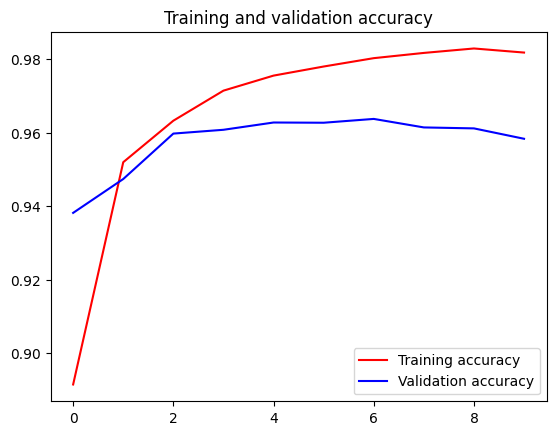

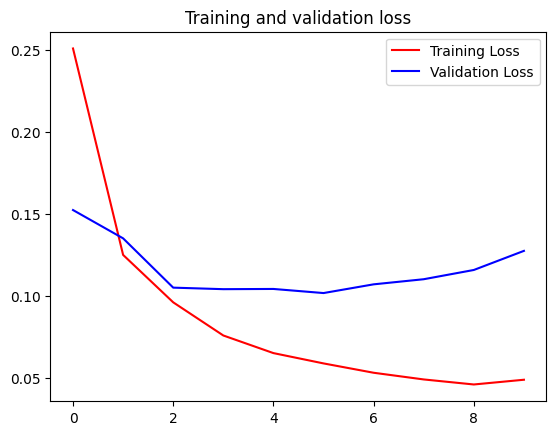

In [102]:
# Visualize Loss & Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

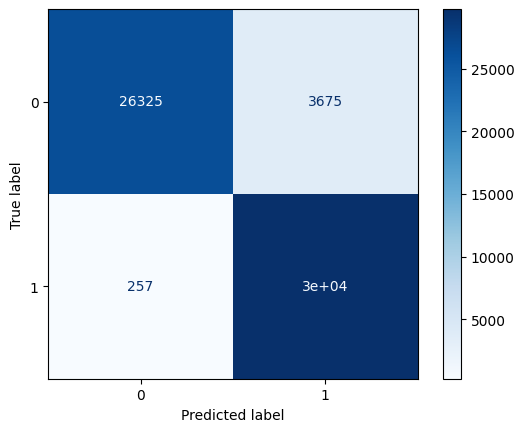

In [104]:
cm = confusion_matrix(np.array(y_test), y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# V2

In [138]:
model_v2 = build_model_v2(params_dict, embedding_matrix)
history, model = fit_model(model_v2, x_train, y_train, x_valid, y_valid, params_dict)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 164, 200)          132196600 
                                                                 
 bidirectional_5 (Bidirecti  (None, 164, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 132927993 (507.08 MB)
Trainable params: 731393 (2.79 MB)
Non-trainable params: 132196600 (504.29 MB)
_________________________________________________________________
Epoch

In [139]:
model_v2.evaluate(x_valid, y_valid, verbose=1) 

1875/1875 [==============================] - 74s 39ms/step - loss: 0.0889 - accuracy: 0.9682


[0.08893194049596786, 0.9681500196456909]

In [140]:
model_v2.evaluate(x_test, y_test, verbose=1) 

1875/1875 [==============================] - 71s 38ms/step - loss: 0.0874 - accuracy: 0.9685


[0.08743561059236526, 0.968500018119812]

In [146]:
predictions = model_v2.predict(x_test)

   1/1875 [..............................] - ETA: 1:30

1875/1875 [==============================] - 74s 39ms/step


In [149]:
y_pred = np.where(predictions.max(axis=-1) > 0.5, 1, 0)

In [152]:
print(classification_report(np.array(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     30000
           1       0.98      0.96      0.97     30000

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



In [153]:
model_v2.save('models/bilstm_model_v2.keras')

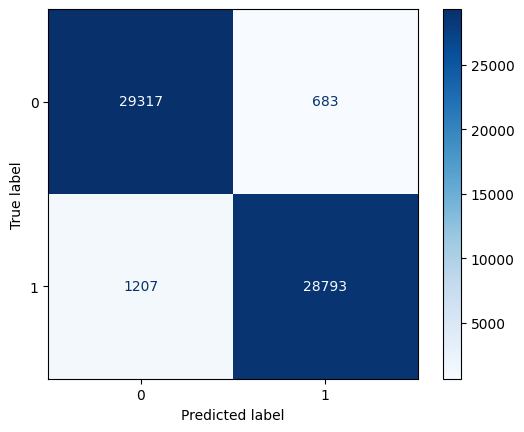

In [154]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# BERT

In [12]:
import ktrain

/home/mfain/anaconda/envs/venv-masters/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# v3

train_set = df[:180000]
valid_set = df[180000:240000]
test_set = df[240000:]

In [18]:
x_train = train_set['preprocessed_text'].tolist()
y_train = np.array(train_set['generated'])

x_test = test_set['preprocessed_text'].tolist()
y_test = np.array(test_set['generated'])

x_valid = valid_set['preprocessed_text'].tolist()
y_valid = np.array(valid_set['generated'])

In [11]:
len(x_train), len(x_valid), len(x_test)

(180000, 60000, 60000)

In [15]:
max_seq_len = 164
class_names = ['not generated', 'generated']

In [19]:
(x_train, y_train), (x_valid, y_valid), preproc = ktrain.text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                    x_test=x_valid, y_test=y_valid,
                                                                    preprocess_mode='bert',
                                                                    class_names=class_names,
                                                                    maxlen=max_seq_len,
                                                                    max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [20]:
model_bert = ktrain.text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 164


2024-04-01 21:13:30.742022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 21:13:30.743709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-01 21:13:30.784430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

done.


In [22]:
learner = ktrain.get_learner(model_bert, train_data=(x_train, y_train), 
                             val_data=(x_valid, y_valid),
                             batch_size=16)

In [24]:
learning_rate = 2e-5
epochs = 3
learner.fit_onecycle(learning_rate, epochs)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3


  602/11250 [>.............................] - ETA: 5:42:59 - loss: 0.2583 - accuracy: 0.8960